In [10]:
import pandas as pd
import numpy as np

np.random.seed(55)  # Para reproducibilidad

n = 10000


temperatura = np.random.normal(loc=22, scale=5, size=n)
personas = np.random.randint(1, 6, size=n).astype(float)  # Convertido a float
electrodomesticos = np.random.randint(5, 21, size=n).astype(float)  # Convertido a float


consumo = (temperatura * 0.8 + personas * 3 + electrodomesticos * 1.5 + np.random.normal(0, 3, n))


for col in [temperatura, personas, electrodomesticos, consumo]:
    idx_nan = np.random.choice(n, size=int(n * 0.05), replace=False)
    col[idx_nan] = np.nan


outlier_idx = np.random.choice(n, size=int(n * 0.01), replace=False)
consumo[outlier_idx] += np.random.normal(100, 20, size=len(outlier_idx))


df = pd.DataFrame({
    'Temperatura': temperatura,
    'Personas': personas,
    'Electrodomesticos': electrodomesticos,
    'Consumo_kWh': consumo
})


df.to_csv('consumo_hogar.csv', index=False)
print("Archivo 'consumo_hogar.csv' generado con éxito.")

Archivo 'consumo_hogar.csv' generado con éxito.


In [11]:
df = pd.read_csv("consumo_hogar.csv")


In [12]:
df.head()

,Temperatura,Personas,Electrodomesticos,Consumo_kWh
0,13.881344,2.0,10.0,33.358546
1,21.491080,1.0,14.0,42.146319
2,12.951045,3.0,NaN,40.213560
3,23.313269,2.0,NaN,46.317235
4,23.299763,3.0,7.0,37.333410


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperatura        9500 non-null   float64
 1   Personas           9500 non-null   float64
 2   Electrodomesticos  9500 non-null   float64
 3   Consumo_kWh        9500 non-null   float64
dtypes: float64(4)
memory usage: 312.6 KB


In [14]:
df.describe()

,Temperatura,Personas,Electrodomesticos,Consumo_kWh
count,9500.000000,9500.000000,9500.000000,9500.000000
mean,22.071692,3.004105,12.498842,46.339578
std,4.973928,1.414245,4.619186,13.897652
min,4.589429,1.000000,5.000000,17.545016
25%,18.687391,2.000000,8.750000,38.476960
50%,22.099179,3.000000,12.000000,45.365429
75%,25.440468,4.000000,17.000000,52.416518
max,45.936826,5.000000,20.000000,193.994953


In [15]:

# Cargar el archivo
df = pd.read_csv("consumo_hogar.csv")

# Verificar valores nulos por columna
print(df.isnull().sum())

# Opciones para tratarlos:
# Imputación con la media
df.fillna(df.mean(numeric_only=True), inplace=True)



Temperatura          500
Personas             500
Electrodomesticos    500
Consumo_kWh          500
dtype: int64


In [16]:
from scipy.stats import zscore

# Definir las columnas numéricas sobre las que quieres calcular el z-score
variables = ['Temperatura', 'Personas', 'Electrodomesticos', 'Consumo_kWh']

# Calcular el z-score absoluto
z_scores = np.abs(zscore(df[variables]))

# Filtrar los registros donde todas las variables están dentro del rango permitido
df_clean = df[(z_scores < 3).all(axis=1)]

# Ver cuántos registros quedaron
print(f"Registros originales: {df.shape[0]}")
print(f"Registros después de eliminar outliers: {df_clean.shape[0]}")



Registros originales: 10000
Registros después de eliminar outliers: 9871


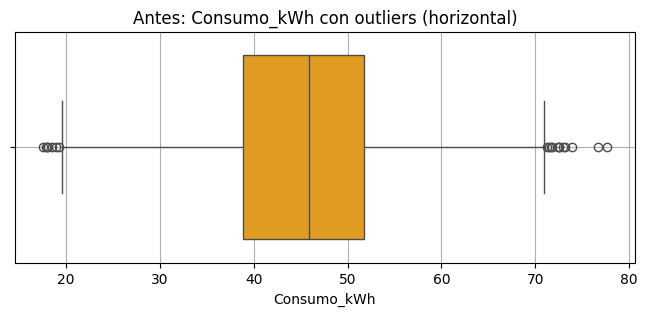

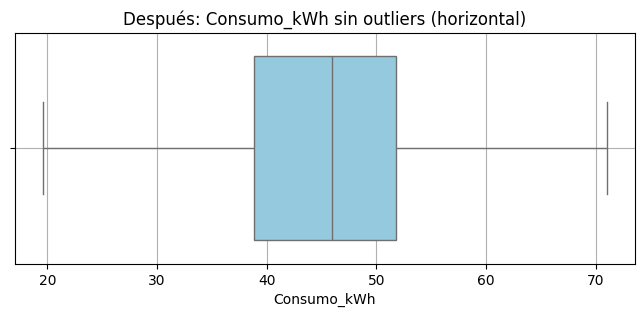

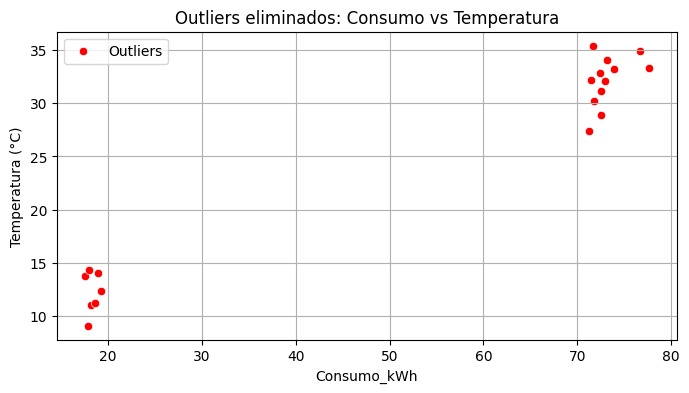

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. BOXPLOT ANTES (con outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(data=df_clean, x='Consumo_kWh', color='orange')
plt.title('Antes: Consumo_kWh con outliers (horizontal)')
plt.grid(True)
plt.show()

# 2. DETECCIÓN con IQR
Q1 = df_clean['Consumo_kWh'].quantile(0.25)
Q3 = df_clean['Consumo_kWh'].quantile(0.75)
IQR = Q3 - Q1

condicion_no_outliers = (df_clean['Consumo_kWh'] >= Q1 - 1.5 * IQR) & (df_clean['Consumo_kWh'] <= Q3 + 1.5 * IQR)
df_sin_outliers = df_clean[condicion_no_outliers]
df_outliers = df_clean[~condicion_no_outliers]

# 3. BOXPLOT DESPUÉS (sin outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(data=df_sin_outliers, x='Consumo_kWh', color='skyblue')
plt.title('Después: Consumo_kWh sin outliers (horizontal)')
plt.grid(True)
plt.show()

# 4. SCATTERPLOT SOLO OUTLIERS (horizontal: eje X = Consumo)
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_outliers, x='Consumo_kWh', y='Temperatura', color='red', label='Outliers')
plt.title('Outliers eliminados: Consumo vs Temperatura')
plt.xlabel('Consumo_kWh')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.show()


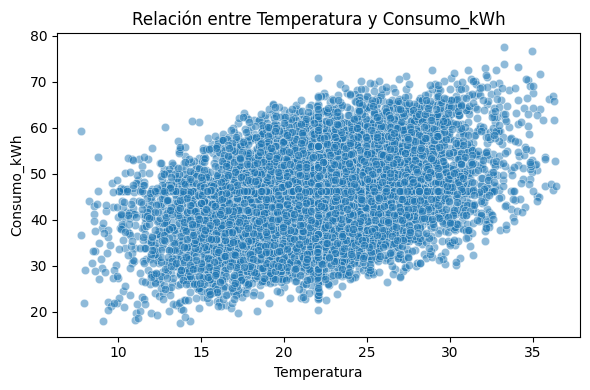

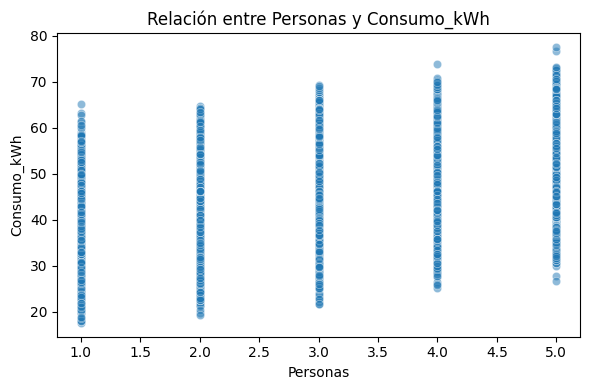

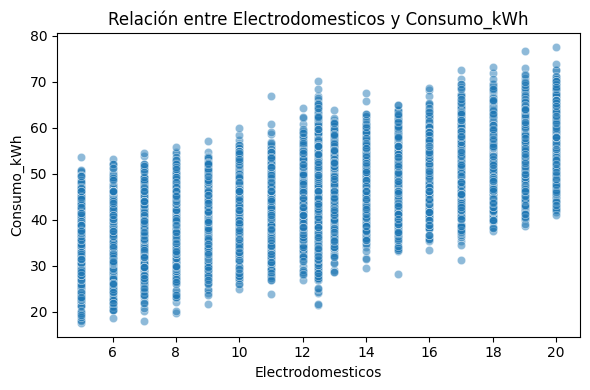

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables independientes
variables_independientes = ['Temperatura', 'Personas', 'Electrodomesticos']

# Crear scatterplots y evaluar visualmente la relación
figures = []
for variable in variables_independientes:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_clean[variable], y=df_clean['Consumo_kWh'], alpha=0.5)
    plt.title(f'Relación entre {variable} y Consumo_kWh')
    plt.xlabel(variable)
    plt.ylabel('Consumo_kWh')
    plt.tight_layout()
    plt.show()


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Variables independientes y dependiente
X = df_clean[['Temperatura', 'Personas', 'Electrodomesticos']]
y = df_clean['Consumo_kWh']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicciones
y_pred_linear = linear_model.predict(X_test)

# Métricas
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Resultados
print("Regresión Lineal Múltiple:")
print("Coeficientes:", linear_model.coef_)
print("Intercepto:", linear_model.intercept_)
print("MSE:", mse_linear)
print("R²:", r2_linear)


Regresión Lineal Múltiple:
Coeficientes: [0.75109203 2.87886955 1.43747565]
Intercepto: 2.225272051876594
MSE: 14.653165131746208
R²: 0.8287656529698018


In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Polinómico grado 2
poly2 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly2.fit(X_train, y_train)

# Predicciones
y_pred_poly2 = poly2.predict(X_test)

# Métricas
mse_poly2 = mean_squared_error(y_test, y_pred_poly2)
r2_poly2 = r2_score(y_test, y_pred_poly2)

print("\nRegresión Polinómica Grado 2:")
print("MSE:", mse_poly2)
print("R²:", r2_poly2)



Regresión Polinómica Grado 2:
MSE: 14.673138559835497
R²: 0.8285322469523254


In [21]:
# Polinómico grado 3
poly3 = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
poly3.fit(X_train, y_train)

# Predicciones
y_pred_poly3 = poly3.predict(X_test)

# Métricas
mse_poly3 = mean_squared_error(y_test, y_pred_poly3)
r2_poly3 = r2_score(y_test, y_pred_poly3)

print("\nRegresión Polinómica Grado 3:")
print("MSE:", mse_poly3)
print("R²:", r2_poly3)



Regresión Polinómica Grado 3:
MSE: 14.683584160572824
R²: 0.8284101814732625


In [25]:
import pandas as pd

# Crear tabla comparativa
resultados = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Polinómica Grado 2'],
    'MSE': [mse_linear, mse_poly2],
    'R²': [r2_linear, r2_poly2]
})

# Añadir resultados del modelo polinómico de grado 3
resultados.loc[len(resultados.index)] = ['Polinómica Grado 3', mse_poly3, r2_poly3]

# Mostrar la tabla
print(resultados)




               Modelo        MSE        R²
0    Regresión Lineal  14.653165  0.828766
1  Polinómica Grado 2  14.673139  0.828532
2  Polinómica Grado 3  14.683584  0.828410


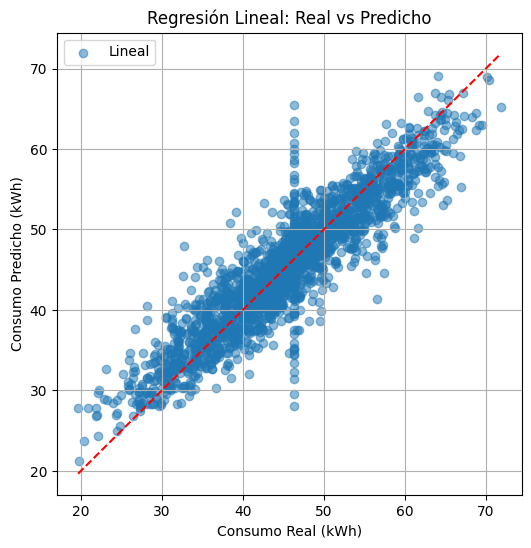

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5, label='Lineal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Consumo Real (kWh)')
plt.ylabel('Consumo Predicho (kWh)')
plt.title('Regresión Lineal: Real vs Predicho')
plt.legend()
plt.grid(True)
plt.show()


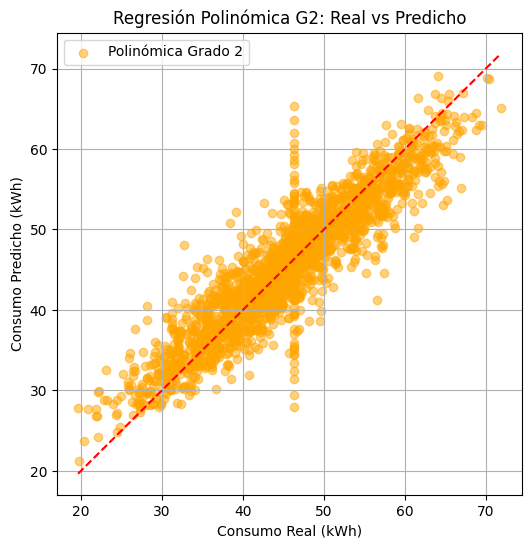

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_poly2, alpha=0.5, color='orange', label='Polinómica Grado 2')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Consumo Real (kWh)')
plt.ylabel('Consumo Predicho (kWh)')
plt.title('Regresión Polinómica G2: Real vs Predicho')
plt.legend()
plt.grid(True)
plt.show()


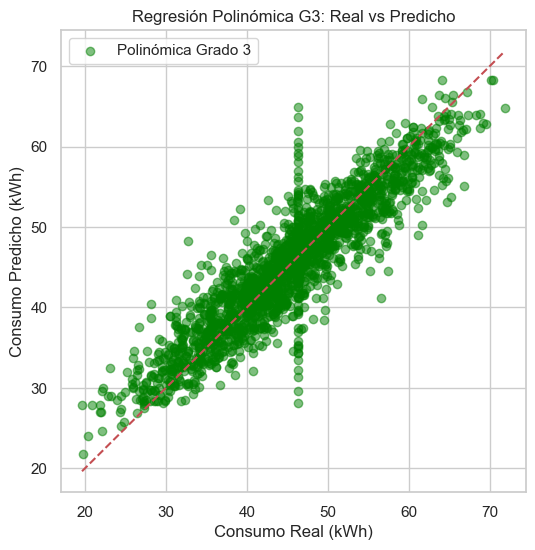

In [61]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_poly3, alpha=0.5, color='green', label='Polinómica Grado 3')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Consumo Real (kWh)')
plt.ylabel('Consumo Predicho (kWh)')
plt.title('Regresión Polinómica G3: Real vs Predicho')
plt.legend()
plt.grid(True)
plt.show()
